**RANDOM FOREST STOCK PREDICTION**

Random Forest is a machine learning technique that works by building lots of decision trees and then combining their results to make better predictions. In the context of stock prediction, it looks at past price patterns and technical indicators—like RSI, MACD, and OBV—to learn what usually happens before a stock goes up or down. Instead of relying on just one prediction, it takes a vote from many trees, which helps make the model more reliable, especially when the data is noisy or unpredictable like in the stock market. This makes it a strong tool for figuring out future stock trends.

Importing libraries for the stock prediction

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
import yfinance as yf

Data preparation and processing

This section of the code pulls Boeing’s stock data from 2015 to 2023 using the yfinance library. To smooth out the day-to-day ups and downs in the stock’s closing price, it applies exponential smoothing, which helps highlight the overall trend. The goal is to figure out whether the stock's price will go up in the next 30 days. To do that, the code looks 30 days ahead for each point in time and checks if the future smoothed price is higher than the current one. If it is, it marks it as a 1 (meaning the stock is expected to rise); otherwise, it’s marked as 0. This gives the model something to learn from when trying to predict future movements.

In [ ]:
# Download historical data for Boeing using yfinance
symbol = "BA"
stock_data = yf.download(symbol, start="2015-01-01", end="2023-12-31")
stock_data.reset_index(inplace=True)
# Apply exponential smoothing to reduce noise in price movements
stock_data['Smoothed_Close'] = stock_data['Close'].ewm(alpha=smoothing_factor, adjust=False).mean()
#  Define prediction target: will the smoothed price increase in 30 days?
lookahead = 30
stock_data['Future_Close'] = stock_data['Smoothed_Close'].shift(-lookahead)
stock_data['Target'] = (stock_data['Future_Close'] > stock_data['Smoothed_Close']).astype(int)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Indicators

This part of the code calculates several commonly used stock market indicators to help the model better understand how the stock has been behaving. It starts with the Price Rate of Change, which looks at how much the price has moved over the last 5 days. Then it calculates the RSI, which tells us if the stock has been rising or falling too quickly—basically checking if it might be overbought or oversold. The MACD measures momentum by comparing short-term and long-term trends. The Stochastic Oscillator and Williams %R both look at where the current price sits compared to its recent highs and lows, which can signal if a trend is gaining or losing strength. Finally, OBV (On-Balance Volume) adds up trading volume depending on whether the price went up or down, helping to show whether buying or selling pressure is building. These indicators give the model a more complete picture of the stock’s recent activity and help it make better predictions.

In [ ]:
# Rate of Change over 5 days
stock_data['PROC'] = stock_data['Close'].pct_change(periods=5)

# Relative Strength Index (RSI)
delta = stock_data['Close'].diff()
gains = delta.clip(lower=0)
losses = -delta.clip(upper=0)
avg_gain = gains.rolling(14).mean()
avg_loss = losses.rolling(14).mean()
rs = avg_gain / avg_loss
stock_data['RSI'] = 100 - (100 / (1 + rs))

# MACD Indicator
ema_fast = stock_data['Close'].ewm(span=12, adjust=False).mean()
ema_slow = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = ema_fast - ema_slow

# Stochastic Oscillator (%K)
lowest_low = stock_data['Low'].rolling(14).min()
highest_high = stock_data['High'].rolling(14).max()
stock_data['Stoch_%K'] = 100 * (stock_data['Close'] - lowest_low) / (highest_high - lowest_low)

# Williams %R
stock_data['Williams_R'] = -100 * (highest_high - stock_data['Close']) / (highest_high - lowest_low)

# On-Balance Volume (OBV)
obv = [0]
for i in range(1, len(stock_data)):
    prev = stock_data['Close'].iloc[i - 1].item()
    curr = stock_data['Close'].iloc[i].item()
    volume = stock_data['Volume'].iloc[i].item()

    if curr > prev:
        obv.append(obv[-1] + volume)
    elif curr < prev:
        obv.append(obv[-1] - volume)
    else:
        obv.append(obv[-1])
stock_data['OBV'] = obv


Model setup

In this part of the code, we first clean up the dataset by removing any rows with missing values—these usually pop up when calculating rolling indicators like moving averages or RSI. After that, we pick out the features we want the model to learn from, such as RSI, MACD, OBV, and others, and assign them to X. The column we're trying to predict—whether the stock will go up or not—is stored in y. We then split the data into training and testing sets, keeping 20% aside for testing. By using stratify=y, we make sure that the mix of "up" and "down" days is balanced in both sets. Finally, we set up a Random Forest model, telling it to build 100 decision trees. It also uses a technique called "out-of-bag" scoring to check its own performance during training, and it adjusts for any imbalance between the two classes. This preps the model to start learning patterns from the stock data so it can make future predictions.

In [ ]:
# Clean up missing data from rolling indicators
stock_data.dropna(inplace=True)

#  Select features and target variable for training
input_features = ['PROC', 'RSI', 'Stoch_%K', 'Williams_R', 'MACD', 'OBV']
X = stock_data[input_features]
y = stock_data['Target']

# Train/test split while keeping class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Build and train the Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    oob_score=True,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', oob_score=True, random_state=42)

Testing and Evaluation

This part of the code is all about checking how well the model actually performs. First, it uses the test data to make predictions and also gives the probability of each prediction being a positive outcome (i.e., the stock going up). It then prints out how accurate the model is and includes an OOB (out-of-bag) score, which is like a built-in performance check during training. The classification report breaks down how well the model did in terms of precision, recall, and F1-score, while the confusion matrix shows how many predictions were right or wrong. Next, it plots a ROC curve, which helps visualize how good the model is at separating upward trends from downward ones—the closer the curve is to the top-left corner, the better. Lastly, it shows which indicators (like RSI or MACD) the model relied on the most when making decisions, giving you insight into what signals mattered most in its predictions.

Model Accuracy: 0.7410
OOB Score: 0.7736

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.65      0.69       200
           1       0.74      0.82      0.78       244

    accuracy                           0.74       444
   macro avg       0.74      0.73      0.73       444
weighted avg       0.74      0.74      0.74       444

Confusion Matrix:
 [[130  70]
 [ 45 199]]


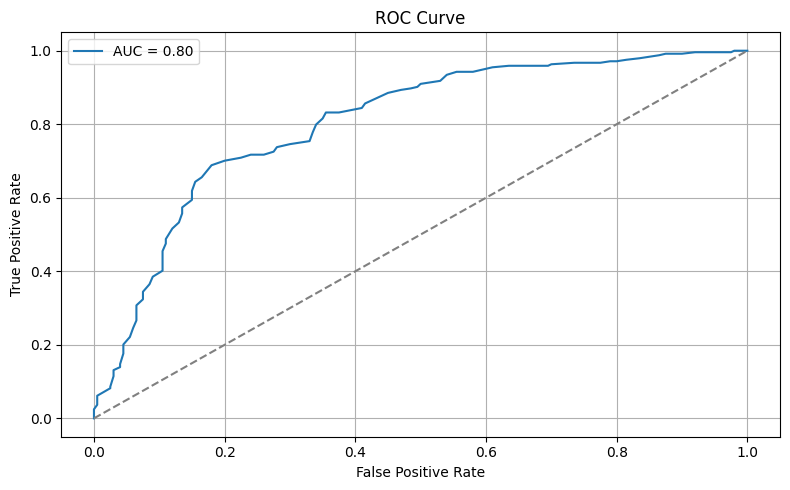

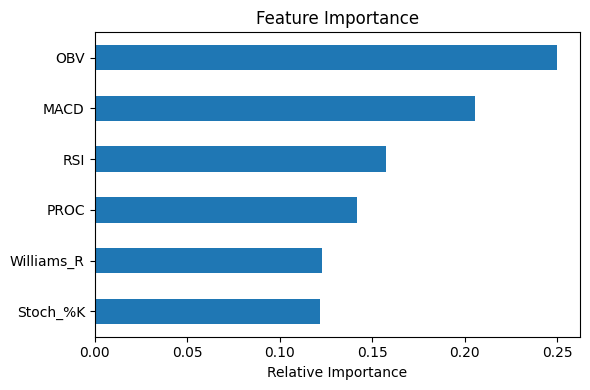

In [ ]:

# Evaluate model performance
predicted = rf_model.predict(X_test)
predicted_probs = rf_model.predict_proba(X_test)[:, 1]

print(f"Model Accuracy: {accuracy_score(y_test, predicted):.4f}")
print(f"OOB Score: {rf_model.oob_score_:.4f}\n")
print("Classification Report:\n", classification_report(y_test, predicted))
print("Confusion Matrix:\n", confusion_matrix(y_test, predicted))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, predicted_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Display feature importance
importances = pd.Series(rf_model.feature_importances_, index=input_features).sort_values()
plt.figure(figsize=(6, 4))
importances.plot(kind='barh')
plt.title("Feature Importance")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()
